In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import hyperopt
import sys
sys.path.append('../spock/')
from simsetup import get_sim
from modelfitting import train_test_split, ROC_curve, stable_unstable_hist, calibration_plot, unstable_error_fraction
try:
    plt.style.use('paper')
except:
    pass
%matplotlib inline

/mnt/ssd/miniconda3/envs/p3/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [7]:
datapath = '../training_data/'
csvpath = '../csvs/'
dset = 'resonant/'
Norbits = 1e4
Nout = 80
featureargs = (Norbits, Nout) # params to pass feature function
featurefolder = 'featuresNorbits{0:.1f}Nout{1}trio/'.format(Norbits, Nout)
trainingdatafolder = datapath+dset+featurefolder
csvfolder = csvpath+dset
print(trainingdatafolder)
print(csvfolder)

../training_data/resonant/featuresNorbits10000.0Nout80trio/
../csvs/resonant/


In [8]:
dataset = pd.read_csv(trainingdatafolder+"trainingdata.csv", index_col = 0)
labels = pd.read_csv(trainingdatafolder+"labels.csv", index_col=0)

In [9]:
def hasnull(row):
    numnulls = row.isnull().sum()
    if numnulls == 0:
        return 0
    else:
        return 1

def tmax(row):
    sim = get_sim(row, csvfolder)
    tmax = 1e4 # replace with a calculation of tmax
    return tmax

In [10]:
near = ['EMcrossnear', 'EMfracstdnear', 'EPstdnear', 'MMRstrengthnear']
far = ['EMcrossfar', 'EMfracstdfar', 'EPstdfar', 'MMRstrengthfar']
megno = ['MEGNO', 'MEGNOstd']

features = near + far + megno

In [ ]:
%%time
dataset['hasnull'] = dataset.apply(hasnull, axis=1)
dataset['tmax'] = dataset.apply(tmax, axis=1)
# dataset['tmax'] = dataset.apply(lambda x:1e4, axis=1) # this version would just set tmax=1e4 for all of them

Now we do the filtering manually. This is taking only systems with instability times > 1e4 AND no NaNs. Would adjust this for each case. 

We were worried that we were using filter=..., which was filtering out any rows that had any NaNs in them. We wanted to compare results when we don't include that filter, and only filtered for instability_time.

In [12]:
dataset.tail()

,EMcrossnear,EMfracstdnear,EPstdnear,MMRstrengthnear,EMcrossfar,EMfracstdfar,EPstdfar,MMRstrengthfar,MEGNO,MEGNOstd,hasnull
113538,0.082222,0.049940,0.016289,0.614960,0.664222,0.031330,0.003745,NaN,76.212769,21.217672,1
113539,0.251338,0.016063,0.002925,0.250122,0.272822,0.002159,0.000486,0.016374,61.260204,9.154976,0
113540,0.131799,0.027693,0.001458,0.660450,0.366664,0.067472,0.020413,0.005440,62.894058,20.937465,0
113541,0.209454,0.090838,0.010214,1.438882,0.395073,0.102280,0.038515,0.041145,63.330790,17.316868,0
113542,0.182523,0.129844,0.040866,0.052307,0.430482,0.050120,0.010405,NaN,NaN,NaN,1


In [ ]:
y = labels[(labels['instability_time'] > 1.e4) & (dataset['hasnull'] == 0)][labelname]
X = dataset[(labels['instability_time'] > 1.e4) & (dataset['hasnull'] == 0)][features]

Now we do the train test split manually. We take 80\% of the rows for training, 20\% for testing (this is what we were doing before too)

In [ ]:
Nrows = int(0.8*X.shape[0])
trainX = X.iloc[:Nrows, :]
trainY = y.iloc[:Nrows]
testX = X.iloc[Nrows:, :]
testY = y.iloc[Nrows:]

dtrain = xgb.DMatrix(trainX, trainY)
dtest = xgb.DMatrix(testX, testY)

Need to go into spock/modelfitting.py, remove train_test_split, and rewrite the other testing functions to only take the arrays they need

In [4]:
space ={'max_depth': hp.qloguniform('x_max_depth', np.log(5), np.log(20), 1),
        'min_child_weight': hp.loguniform('x_min_child', 0, np.log(20)),
        'subsample': hp.uniform ('x_subsample', 0.8, 1),
}

def objective(params):
    clf = XGBClassifier(n_jobs=16, n_estimators = 50,
                            max_depth = int(params['max_depth']), 
                            min_child_weight = params['min_child_weight'],
                            subsample = params['subsample'],
                            learning_rate = 0.15, seed = 0)
    
    score = xgb.cv(clf.get_xgb_params(), dtrain, nfold = 5, metrics = "auc", early_stopping_rounds=10)
    avg_score =  np.mean(score["test-auc-mean"])
    error = np.mean(score["test-auc-std"])
    
    print("SCORE:", avg_score, "ERROR", error)#, "HOLDOUT SCORE", test_score)
    return{'loss':1-avg_score, 'status': STATUS_OK, "cv_score":avg_score , "cv_error":error}


In [6]:
%%time
trials = Trials()
import time
start = time.time()
best = fmin(fn=objective, space = space, algo = tpe.suggest, max_evals = 100, trials = trials, rstate=np.random.RandomState(seed=0))
end = time.time()
print("Optimization Time: %f seconds", (end  -start))

SCORE:                                                                          
0.90542088                                                                      
ERROR                                                                           
0.001481973009736162                                                            
SCORE:                                                                          
0.9059759399999999                                                              
ERROR                                                                           
0.0013567907806720256                                                           
SCORE:                                                                          
0.90302234                                                                      
ERROR                                                                           
0.001918144211492776                                                            
SCORE:                      

ERROR                                                                           
0.001915222475052318                                                            
SCORE:                                                                          
0.89073832                                                                      
ERROR                                                                           
0.0019098584071966154                                                           
SCORE:                                                                          
0.9057089600000001                                                              
ERROR                                                                           
0.0018541559813218776                                                           
SCORE:                                                                          
0.9057634                                                                       
ERROR                       

# max_depth controls depth of trees

12 lets the model use all the features and improvements seem minor beyond that

Text(0, 0.5, 'CV AUC')

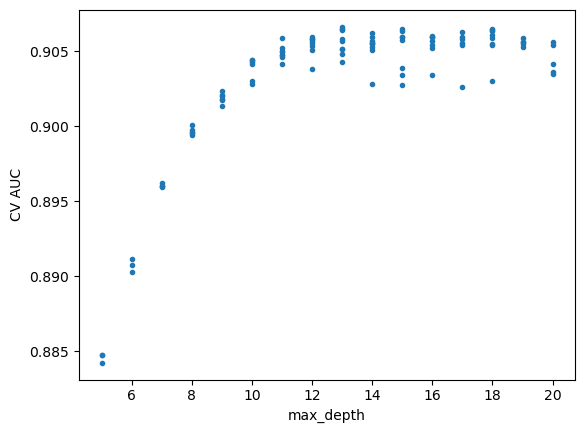

In [7]:
depths = trials.vals['x_max_depth']
min_childs = trials.vals['x_min_child']
aucs = np.array([1-x['loss'] for x in trials.results])

fig, ax = plt.subplots()
ax.plot(depths, aucs, '.')
ax.set_xlabel('max_depth')
ax.set_ylabel('CV AUC')

# min child weight acts as a regularizer, penalizing complex models. Larger min_child_weight = larger penalization

Text(0, 0.5, 'CV AUC')

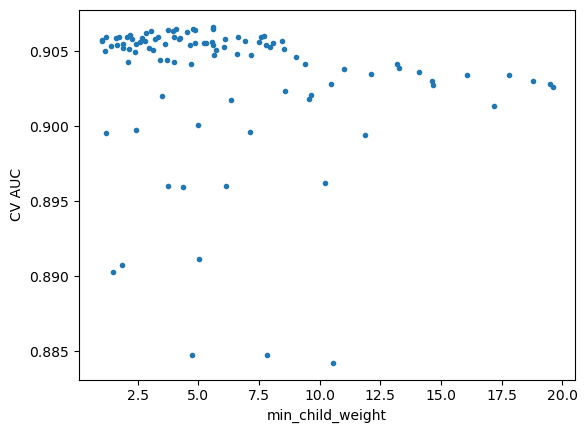

In [8]:
fig, ax = plt.subplots()
ax.plot(min_childs, aucs, '.')
ax.set_xlabel('min_child_weight')
ax.set_ylabel('CV AUC')

Text(0, 0.5, 'min_child_weight')

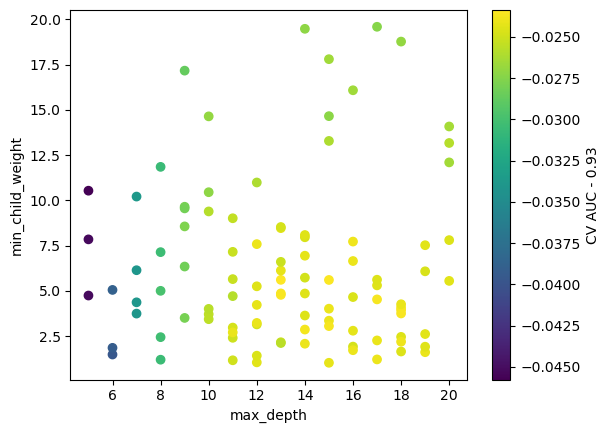

In [9]:
fig, ax = plt.subplots()
cb = ax.scatter(depths, min_childs, c=aucs-0.93)
plt.colorbar(cb, label='CV AUC - 0.93')
ax.set_xlabel('max_depth')
ax.set_ylabel('min_child_weight')

# Marginal improvements beyond max_depth of 13, so choose the least complex model

In [ ]:
model = XGBClassifier(learning_rate = 0.03, 
                         max_depth = 20, 
                         subsample = 0.95,
                         min_child_weight = 5)

score = xgb.cv(model.get_xgb_params(), dtrain, nfold = 5, metrics = "auc", verbose_eval=True, num_boost_round=400)

[0]	train-auc:0.92870+0.00059	test-auc:0.88488+0.00278
[1]	train-auc:0.93896+0.00087	test-auc:0.89418+0.00231
[2]	train-auc:0.94342+0.00027	test-auc:0.89854+0.00281
[3]	train-auc:0.94616+0.00031	test-auc:0.90112+0.00194
[4]	train-auc:0.94785+0.00030	test-auc:0.90249+0.00251
[5]	train-auc:0.94941+0.00063	test-auc:0.90382+0.00232
[6]	train-auc:0.95066+0.00076	test-auc:0.90522+0.00265
[7]	train-auc:0.95183+0.00071	test-auc:0.90596+0.00223
[8]	train-auc:0.95304+0.00068	test-auc:0.90704+0.00224
[9]	train-auc:0.95397+0.00064	test-auc:0.90770+0.00218
[10]	train-auc:0.95470+0.00057	test-auc:0.90801+0.00210


# Going beyond ~100 trees does not improve CV, so cut off training there to avoid overfitting

In [ ]:
n_estimators = 100
fig, ax = plt.subplots()
ax.plot(score.index, score['train-auc-mean'], label='Train')
ax.plot(score.index, score['test-auc-mean'], label='Test')
ax.axvline(n_estimators, linestyle='--')
ax.legend()
ax.set_xlabel('n_estimators (num trees)')
ax.set_ylabel('CV AUC score')

In [ ]:
model.set_params(n_estimators = n_estimators)
model.fit(trainX, trainY)

In [ ]:
model.save_model(datapath+'../spock/models/spock_fixtmax_filterTmax.json')

In [ ]:
model = XGBClassifier()
model.load_model(datapath+'../spock/models/spock_fixtmax_filterTmax.json')

# SPOCK

/mnt/ssd/miniconda3/envs/yba/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Text(0.5, 1.0, 'ROC curve (AUC = 0.928)')

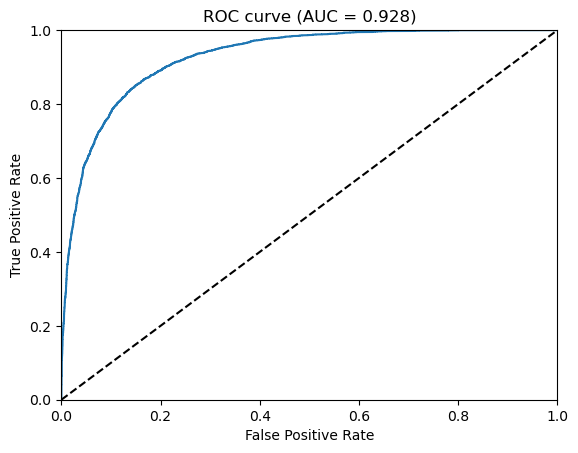

In [15]:
roc_auc, fpr, tpr, ROCthresholds = ROC_curve(trainingdatafolder, model, features,filter = 'tmax')

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(roc_auc))

In [ ]:
stride = 10
np.savetxt('../spock/models/resROC.txt', (ROCthresholds[::stride], tpr[::stride], fpr[::stride]))

In [ ]:
ROCthresholds, tpr, fpr = np.loadtxt('../spock/models/resROC.txt')
for i in range(0,len(tpr), 15):
    print("Threshold {0}, TPR = {1}, FPR = {2}".format(ROCthresholds[i], tpr[i], fpr[i]))

In [ ]:
# feature importances
feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
ax = feat_imp.plot.barh(figsize=(12,8), fontsize=24)
ax.set_xlabel('Feature Importance Score', fontsize=24)
ax.invert_yaxis()
plt.savefig('featureimportances.pdf', bbox_inches='tight')

In [ ]:
feat_imp

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, confusion_matrix, auc
from sklearn import metrics

In [ ]:
def hasnull(row):
    numnulls = row.isnull().sum()
    if numnulls == 0:
        return 0
    else:
        return 1

In [ ]:
def test_split(trainingdatafolder, features=None, labelname='Stable', filter=False, filtertimes=False):
    dataset = pd.read_csv(trainingdatafolder+"trainingdata.csv", index_col = 0)
    if features is None:
        features = dataset.columns.values
    dataset['hasnull'] = dataset.apply(hasnull, axis=1)

    labels = pd.read_csv(trainingdatafolder+"labels.csv", index_col=0)
    if filter:
        y = labels[(labels['instability_time'] > 1.e4) & (dataset['hasnull'] == 0)][labelname]
        X = dataset[(labels['instability_time'] > 1.e4) & (dataset['hasnull'] == 0)][features]
        tmax = labels['tmax']
    elif filtertimes:
        y = labels[labels['instability_time'] > 1.e4][labelname]
        X = dataset[labels['instability_time'] > 1.e4][features]
        tmax = labels['tmax']
    else:
        y = labels[labelname]
        X = dataset[features]
        tmax = labels['tmax']
    return X,y,tmax

In [ ]:
def train_test_split(trainingdatafolder, features=None, labelname='Stable', filter=False, filtertimes=False):
    dataset = pd.read_csv(trainingdatafolder+"trainingdata.csv", index_col = 0)
    if features is None:
        features = dataset.columns.values
    dataset['hasnull'] = dataset.apply(hasnull, axis=1)
    labels = pd.read_csv(trainingdatafolder+"labels.csv", index_col=0)
    if filter:
        y = labels[(labels['instability_time'] > 1.e4) & (dataset['hasnull'] == 0)][labelname]
        X = dataset[(labels['instability_time'] > 1.e4) & (dataset['hasnull'] == 0)][features]
        tmax = labels[(labels['instability_time'] > 1.e4) & (dataset['hasnull'] == 0)]['tmax']
    elif filtertimes:
        y = labels[labels['instability_time'] > 1.e4][labelname]
        X = dataset[labels['instability_time'] > 1.e4][features]
        tmax = labels[labels['instability_time'] > 1.e4]['tmax']
    else:
        y = labels[labelname]
        X = dataset[features]
        tmax = labels['tmax']
    Nrows = int(0.8*X.shape[0])
    print(Nrows)
    trainX = X.iloc[:Nrows, :]
    trainy = y.iloc[:Nrows]
    train_tmax = tmax.iloc[:Nrows]
    testX = X.iloc[Nrows:, :]
    testy = y.iloc[Nrows:]
    test_tmax = tmax.iloc[Nrows:]
    return trainX, trainy, testX, testy, train_tmax, test_tmax

In [ ]:
#print everything (Don't change it)
train_test_split(trainingdatafolder, features, filter=filter, filtertimes=False)

In [ ]:
#print tmax
trainX, trainy, testX, testy, train_tmax, test_tmax =train_test_split(trainingdatafolder, features, filter=True, filtertimes=False)

In [ ]:
trainX

In [ ]:
trainX.info()

In [ ]:
trainY

In [ ]:
train_tmax

In [ ]:
testX

In [ ]:
if 110000 in testX.index:
    # Retrieve the row with index 11000
    row_11000 = testX.loc[110000]
    print(row_11000)


In [ ]:
testX.iloc[11000][1]
preds = model.predict_proba(testX)[:,1]
print(preds)

In [ ]:
testY

In [ ]:
test_tmax

In [ ]:
test_tmax[110000]

In [ ]:
type(testX)

In [ ]:
trainX, trainy, testX, testy, train_tmax, test_tmax = train_test_split(trainingdatafolder, features, filter=False, filtertimes=False)

In [ ]:
preds = model.predict_proba(testX)[:,1]
stablepreds = preds[np.where(testy==1)]
tmax_stable = np.array(test_tmax)[np.where(testy==1)]
unstablepreds = preds[np.where(testy==0)]
tmax_unstable = np.array(test_tmax)[np.where(testy==0)]

In [ ]:
preds[11000]

In [ ]:
type(tmax)

In [ ]:
type(preds)

In [ ]:
fig, ax = plt.subplots()
ax.scatter(stablepreds,np.log10(tmax_stable),s=1)

In [ ]:
!pip install seaborn

In [ ]:
plt.scatter(stablepreds, np.log10(tmax_stable), alpha=0.1)  # Adjust alpha for transparency
plt.xlabel('Probability (stable_preds)')
plt.ylabel('log10(tmax)')
plt.title('Scatter Plot of stable_preds vs log10(tmax) with Transparency')
plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.scatter(unstablepreds,np.log10(tmax_unstable),s=1)

In [ ]:
preds = model.predict_proba(trainX)[:,1]
stablepreds = preds[np.where(trainy==1)]
tmax_stable = np.array(train_tmax)[np.where(trainy==1)]
unstablepreds = preds[np.where(trainy==0)]
tmax_unstable = np.array(train_tmax)[np.where(trainy==0)]

In [ ]:
fig, ax = plt.subplots()
ax.scatter(stablepreds,np.log10(tmax_stable),s=1)

In [ ]:
preds.shape

In [ ]:
# Histogram:
bins = 50
Stable, Unstable = stable_unstable_hist(trainingdatafolder, model, features)
print(Unstable)

fig, ax1 = plt.subplots()
n, bins, patches = ax1.hist(Unstable, bins, alpha=0.5, label='No', color='blue', edgecolor = "black")
ax1.set_xlabel('Predicted Probability', fontsize=14)
ax1.set_ylabel('Unstable',  fontsize=14, color='blue')
for tl in ax1.get_yticklabels():
    tl.set_color('blue')
    
ax2 = ax1.twinx()
n, bins , patches = ax2.hist(Stable, bins, alpha=0.5, label='Yes',color='green', edgecolor = "black")
ax2.set_ylabel('Stable', fontsize=14, color='green')
for tl in ax2.get_yticklabels():
    tl.set_color('green')
       
ax1.set_ylim([0,35*n[-1]]) # goes up to ~4300
ax2.set_ylim([0,1.1*n[-1]]) # goes up to ~2100
fig.savefig('stable_unstable_comparison.png')

In [ ]:
# Assuming stable_unstable_hist is modified to return test_tmax
Stable, Unstable, test_tmax = stable_unstable_hist(trainingdatafolder, model, features)
print(Unstable)

fig, ax1 = plt.subplots()

# Plotting the Unstable histogram
n, bins, patches = ax1.hist(Unstable, bins, alpha=0.5, label='No', color='blue', edgecolor="black")
ax1.set_xlabel('Predicted Probability', fontsize=14)
ax1.set_ylabel('Unstable', fontsize=14, color='blue')
for tl in ax1.get_yticklabels():
    tl.set_color('blue')

# Plotting the Stable histogram
ax2 = ax1.twinx()
n, bins, patches = ax2.hist(Stable, bins, alpha=0.5, label='Yes', color='green', edgecolor="black")
ax2.set_ylabel('Stable', fontsize=14, color='green')
for tl in ax2.get_yticklabels():
    tl.set_color('green')

# Adding the test_tmax vs stablepreds line plot
sorted_indices = np.argsort(test_tmax)
sorted_tmax = test_tmax[sorted_indices]
sorted_stablepreds = Stable[sorted_indices]
ax2.plot(sorted_tmax, sorted_stablepreds, label='Test Tmax vs Spock Prob', color='red', linewidth=2)

# Setting the limits for the y-axis
ax1.set_ylim([0, 35 * n[-1]])
ax2.set_ylim([0, 1.1 * n[-1]])

# Adding a legend
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

fig.savefig('stable_unstable_comparison.png')


In [ ]:
trainX, trainy, testX, testy, train_tmax, test_tmax = train_test_split(trainingdatafolder, features, filter=filter, filtertimes=False)

In [ ]:
bincenters, fracstable, errorbars = calibration_plot(trainingdatafolder, model, features, bins=8)
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(np.linspace(0,1,100), np.linspace(0,1,100), '--')
ax.errorbar(bincenters, fracstable, errorbars)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_xlabel('Predicted Probability of Stability')
ax.set_ylabel('Fraction actually stable')

In [ ]:
thresh = 0.34 # for 10% FPR
bincenters, errorfracs, errorbars = unstable_error_fraction(trainingdatafolder, model, thresh, features, bins=10)
fig, ax = plt.subplots(figsize=(8,6))
ax.errorbar(bincenters, errorfracs, errorbars)
ax.set_ylim([0,1])
ax.set_xlabel('Log Instability Time')
ax.set_ylabel('Error Fraction')
ax.set_title('Fraction of unstable systems mislabeled as stable')